# 1. Libraries

In [1]:
!pip install strkernel

In [2]:
import time
from strkernel import gappy_kernel as gk
from strkernel import gappy_trie as gt
from scipy.sparse import coo_matrix, vstack
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from Bio.Seq import Seq
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import StackingClassifier

/opt/conda/lib/python3.7/site-packages/strkernel/gappy_trie.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  s=np.array([np.arange(4),np.arange(4),np.arange(20),np.arange(21)])


# 2. Data Sequence PreProcessing

In [3]:
# Reads in files
def read(fname):
    sequences=[]
    with open(fname,'r') as f:
        for line in f:
            if line[0]!='>':
                sequences.append(line.split()[0])
    return sequences

pos=[Seq(x) for x in read('../input/coronavirus-accession-sars-mers-cov2/cov2.fasta')]
neg=[Seq(x) for x in read('../input/coronavirus-accession-sars-mers-cov2/mers.fasta')]
start = time.time()
k=1
g=2
start = time.time()
spectrum_pos = gk.gappypair_kernel(pos, k=k, g=g,  include_flanking=False, gapDifferent = True, sparse = True)
print ("Calculated {}-gappypair in {} seconds".format(k, time.time() - start))
start = time.time()
spectrum_neg = gk.gappypair_kernel(neg,k=k, g=g,  include_flanking=False, gapDifferent = True, sparse = True)
print ("Calculated {}-gappypair in {} seconds".format(k, time.time() - start))
start = time.time()
spectrum_pos3 = gk.gappypair_kernel(pos, k=k, g=g,  include_flanking=False, gapDifferent = False, sparse = True)
print ("Calculated {}-gappypair in {} seconds".format(k, time.time() - start))
start = time.time()
spectrum_neg3 = gk.gappypair_kernel(neg, k=k, g=g,  include_flanking=False, gapDifferent = False, sparse = True)
print ("Calculated {}-gappypair in {} seconds".format(k, time.time() - start))

Calculated 1-gappypair in 0.8655624389648438 seconds
Calculated 1-gappypair in 0.8660333156585693 seconds
Calculated 1-gappypair in 0.8650596141815186 seconds
Calculated 1-gappypair in 0.8751652240753174 seconds


In [4]:
y = np.concatenate((np.ones(spectrum_pos.shape[0]), -np.ones(spectrum_neg.shape[0])))
X =  vstack([spectrum_pos,spectrum_neg]).toarray()
y3 = np.concatenate((np.ones(spectrum_pos3.shape[0]), -np.ones(spectrum_neg3.shape[0])))
X3 =  vstack([spectrum_pos3,spectrum_neg3]).toarray()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=42,stratify=y)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,y3,test_size=0.1,random_state=42,stratify=y3)

# 3. Machine Learning

## 3.1 Support Vector Machines

In [6]:
start = time.time()
clf = SVC(C=0.1, kernel='linear', probability=True)
clf.fit(X_train, y_train)
print ("Trained linear SVM on {}-spectrum in {} seconds".format(k, time.time() - start))

Trained linear SVM on 1-spectrum in 0.2594771385192871 seconds


In [7]:
start = time.time()
clf3 = SVC(C=0.1, kernel='linear', probability=True)
clf3.fit(X_train3, y_train3)
print ("Trained linear SVM on {}-spectrum in {} seconds".format(k, time.time() - start))

Trained linear SVM on 1-spectrum in 0.27106428146362305 seconds


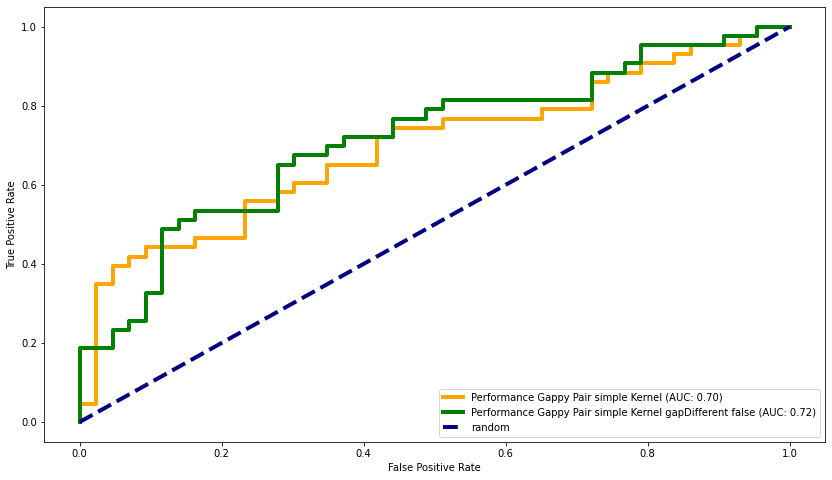

In [8]:
y_score = clf.predict_proba(X_test)
roc_auc = roc_auc_score(y_score=y_score[:,1], y_true=y_test)
tpr, fpr, _ = roc_curve(y_score=y_score[:,1], y_true=y_test)
y_score3 = clf3.predict_proba(X_test3)
roc_auc3 = roc_auc_score(y_score=y_score3[:,1], y_true=y_test3)
tpr3, fpr3, _ = roc_curve(y_score=y_score3[:,1], y_true=y_test3)
fig = plt.figure(figsize=(14, 8))
plt.plot(tpr, fpr, label='Performance Gappy Pair simple Kernel (AUC: {:0.2f})'.format(roc_auc), lw=4, color='orange')
plt.plot(tpr3, fpr3, label='Performance Gappy Pair simple Kernel gapDifferent false (AUC: {:0.2f})'.format(roc_auc3),lw=4, color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', lw=4, linestyle='--', label='random')
plt.legend(loc='lower right')
fig.savefig('./Gappy_Kernel.pdf')

In [9]:
# Necessary, because the gappy pair trie kernel at the moment can't handle N nucleotides
def remove_n(seqs):
    data=[]
    for x in seqs:
        if Seq('N') in x:
            pass
        else:
            data.append(x)
    return data

neg_without_n=remove_n(neg)

start = time.time()
spectrum_pos2 = gt.gappypair_kernel(pos, k, 0, g=g,  include_flanking=False, gapDifferent = False)
print ("Calculated {}-gappypair trie in {} seconds".format(k, time.time() - start))
start = time.time()
spectrum_neg2 = gt.gappypair_kernel(neg_without_n, k, 0, g=g,  include_flanking=False,gapDifferent = False)
print ("Calculated {}-gappypair trie in {} seconds".format(k, time.time() - start))

/opt/conda/lib/python3.7/site-packages/strkernel/gappy_trie.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([np.array([alphabets[t].index(p) for p in x if ('A' <= p <= 'Z') & (p in alphabets[t])]) for x in sequences])


Calculated 1-gappypair trie in 2.295283317565918 seconds
Calculated 1-gappypair trie in 2.319594144821167 seconds


In [10]:
X2 =  vstack([spectrum_pos2,spectrum_neg2]).toarray()
y2 =  np.concatenate((np.ones(spectrum_pos2.shape[0]), -np.ones(spectrum_neg2.shape[0])))

In [11]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2,test_size=0.1,random_state=42,stratify=y2)

In [12]:
start = time.time()
clf2 = SVC(C=0.1, kernel='linear', probability=True)
clf2.fit(X_train2, y_train2)
print ("Trained linear SVM on {}-spectrum in {} seconds".format(k, time.time() - start))

Trained linear SVM on 1-spectrum in 0.30858588218688965 seconds


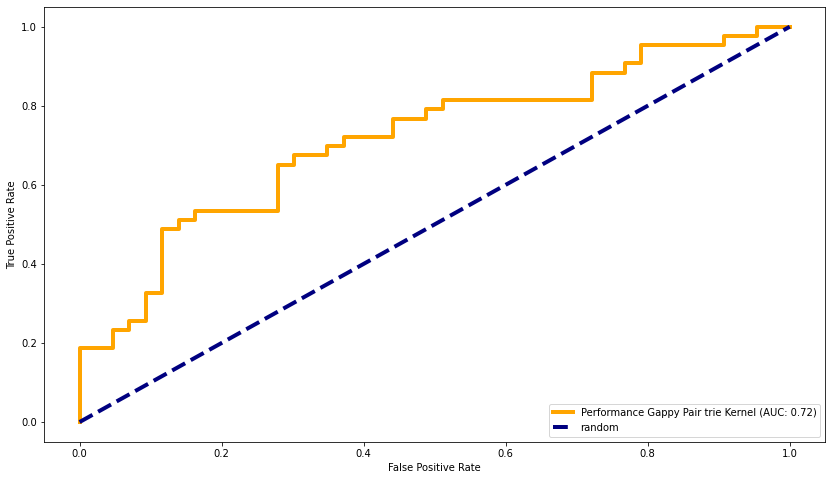

In [13]:
y_score2 = clf2.predict_proba(X_test2)
roc_auc2 = roc_auc_score(y_score=y_score2[:,1], y_true=y_test2)
tpr, fpr, _ = roc_curve(y_score=y_score2[:,1], y_true=y_test2)
fig = plt.figure(figsize=(14, 8))
plt.plot(tpr, fpr, label='Performance Gappy Pair trie Kernel (AUC: {:0.2f})'.format(roc_auc2),         lw=4, color='orange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', lw=4, linestyle='--', label='random')
plt.legend(loc='lower right')

In [14]:
start = time.time()
gk.gappypair_kernel(pos, k=k, g=g,  include_flanking=False, reverse=True, gapDifferent = True)
print ("Calculated {}-gappypair in {} seconds".format(k, time.time() - start))
start = time.time()
gk.gappypair_kernel(pos,k=k, g=g,  include_flanking=True, gapDifferent = True)
print ("Calculated {}-gappypair in {} seconds".format(k, time.time() - start))
start = time.time()
gk.gappypair_kernel(pos, k=k, g=g,  include_flanking=False, reverse =True, gapDifferent = False)
print ("Calculated {}-gappypair in {} seconds".format(k, time.time() - start))
start = time.time()
gk.gappypair_kernel(pos, k=k, g=g,  include_flanking=True, gapDifferent = False)
print ("Calculated {}-gappypair in {} seconds".format(k, time.time() - start))
start = time.time()
gk.gappypair_kernel(pos, k=k, g=4,  include_flanking=False, gapDifferent = True)
print ("Calculated {}-gappypair in {} seconds".format(k, time.time() - start))
start = time.time()
gk.gappypair_kernel(pos, k=k, g=4,  include_flanking=False, gapDifferent = False)
print ("Calculated {}-gappypair in {} seconds".format(k, time.time() - start))

Calculated 1-gappypair in 0.873117208480835 seconds
Calculated 1-gappypair in 1.2057995796203613 seconds
Calculated 1-gappypair in 0.8713433742523193 seconds
Calculated 1-gappypair in 1.2237598896026611 seconds
Calculated 1-gappypair in 1.3857753276824951 seconds
Calculated 1-gappypair in 1.3838868141174316 seconds


##### 

## 3.2 k-Nearest Neighbor

In [15]:
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [16]:
y_pred = knn.predict(X_test)

In [17]:
result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, y_pred)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,y_pred)
print("Accuracy:",result2)

Confusion Matrix:
[[37  6]
 [27 16]]
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.58      0.86      0.69        43
         1.0       0.73      0.37      0.49        43

    accuracy                           0.62        86
   macro avg       0.65      0.62      0.59        86
weighted avg       0.65      0.62      0.59        86

Accuracy: 0.6162790697674418


In [18]:
knn2 = KNeighborsClassifier(n_neighbors = 2)
knn2.fit(X_train2, y_train2)

KNeighborsClassifier(n_neighbors=2)

In [19]:
y_pred2 = knn2.predict(X_test2)

In [20]:
result = confusion_matrix(y_test2, y_pred2)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test2, y_pred2)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test2,y_pred2)
print("Accuracy:",result2)

Confusion Matrix:
[[37  6]
 [34  9]]
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.52      0.86      0.65        43
         1.0       0.60      0.21      0.31        43

    accuracy                           0.53        86
   macro avg       0.56      0.53      0.48        86
weighted avg       0.56      0.53      0.48        86

Accuracy: 0.5348837209302325


In [21]:
knn3 = KNeighborsClassifier(n_neighbors = 2)
knn3.fit(X_train3, y_train3)

KNeighborsClassifier(n_neighbors=2)

In [22]:
y_pred3 = knn3.predict(X_test3)

In [23]:
result = confusion_matrix(y_test3, y_pred3)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test3, y_pred3)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test3,y_pred3)
print("Accuracy:",result2)

Confusion Matrix:
[[37  6]
 [34  9]]
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.52      0.86      0.65        43
         1.0       0.60      0.21      0.31        43

    accuracy                           0.53        86
   macro avg       0.56      0.53      0.48        86
weighted avg       0.56      0.53      0.48        86

Accuracy: 0.5348837209302325


## 3.3 Ensemble Learning

In [24]:
estimators=[("knn", knn), ("svm", clf)]
estimators2=[("knn2", knn2), ("svm2", clf2)]
estimators3=[("knn3", knn3), ("svm3", clf3)]

### 3.3.1 - Ensemble Stacking (First Models)

In [25]:
ensemble_stack = StackingClassifier(estimators=estimators)

ensemble_stack.fit(X_train, y_train)

ensemble_stack.score(X_test, y_test)
y_pred = ensemble_stack.predict(X_test)

In [26]:
result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, y_pred)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,y_pred)
print("Accuracy:",result2)

Confusion Matrix:
[[23 20]
 [13 30]]
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.64      0.53      0.58        43
         1.0       0.60      0.70      0.65        43

    accuracy                           0.62        86
   macro avg       0.62      0.62      0.61        86
weighted avg       0.62      0.62      0.61        86

Accuracy: 0.6162790697674418


### 3.3.2 - Ensemble Stacking (Second Models)

In [27]:
ensemble_stack = StackingClassifier(estimators=estimators2)

ensemble_stack.fit(X_train2, y_train2)

ensemble_stack.score(X_test2, y_test2)
y_pred2 = ensemble_stack.predict(X_test2)

In [28]:
result = confusion_matrix(y_test2, y_pred2)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test2, y_pred2)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test2,y_pred2)
print("Accuracy:",result2)

Confusion Matrix:
[[23 20]
 [12 31]]
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.66      0.53      0.59        43
         1.0       0.61      0.72      0.66        43

    accuracy                           0.63        86
   macro avg       0.63      0.63      0.62        86
weighted avg       0.63      0.63      0.62        86

Accuracy: 0.627906976744186


### 3.3.2 - Ensemble Stacking (Third Models)

In [29]:
ensemble_stack = StackingClassifier(estimators=estimators3)

ensemble_stack.fit(X_train3, y_train3)

ensemble_stack.score(X_test3, y_test3)
y_pred3 = ensemble_stack.predict(X_test3)

In [30]:
result = confusion_matrix(y_test3, y_pred3)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test3, y_pred3)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test3,y_pred3)
print("Accuracy:",result2)

Confusion Matrix:
[[23 20]
 [13 30]]
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.64      0.53      0.58        43
         1.0       0.60      0.70      0.65        43

    accuracy                           0.62        86
   macro avg       0.62      0.62      0.61        86
weighted avg       0.62      0.62      0.61        86

Accuracy: 0.6162790697674418
